In [18]:
from modules.SignLanguageProcessor import load_and_preprocess_data,parse_frame
import os

In [19]:
ROOT_PATH = ''
sequences,labels,label_map = load_and_preprocess_data(os.path.join(ROOT_PATH,'data'))

In [20]:
num_classes = len(label_map)

In [21]:
len(labels)

3413

In [22]:
sequences.shape

(3413, 3, 61, 3)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [24]:
import numpy as np
def normalize_landmark_data(X):
    """
    Normalize the landmark features (x, y) to have zero mean and unit variance across the training set.
    Assumes X shape is (N, F, L, T), where F=3 (x, y, vis).
    """
    X = X.copy()
    # Flatten across all samples, landmarks, and frames
    x_vals = X[:, 0, :, :].flatten()
    y_vals = X[:, 1, :, :].flatten()

    # Compute mean and std
    x_mean, x_std = np.mean(x_vals), np.std(x_vals)
    y_mean, y_std = np.mean(y_vals), np.std(y_vals)

    # Normalize
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std

    return X, (x_mean, x_std), (y_mean, y_std)

def apply_normalization(X, x_mean, x_std, y_mean, y_std):
    X = X.copy()
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std
    return X


In [25]:
def reshape_frames_for_cnn(X, y):
    X = X.transpose(0, 3, 2, 1)  # (N, T, L, F)
    X = X[..., np.newaxis]       # (N, T, L, F, 1)
    return X,y

In [26]:

X_train_norm, (x_mean, x_std), (y_mean, y_std) = normalize_landmark_data(X_train)
X_val_norm  = apply_normalization(X_val, x_mean, x_std, y_mean, y_std)
X_test_norm = apply_normalization(X_test, x_mean, x_std, y_mean, y_std)

X_train_cnn, y_train_cnn = reshape_frames_for_cnn(X_train_norm, y_train)
X_val_cnn, y_val_cnn     = reshape_frames_for_cnn(X_val_norm, y_val)
X_test_cnn, y_test_cnn   = reshape_frames_for_cnn(X_test_norm, y_test)

print(X_train_cnn.shape)  
print(y_train_cnn.shape)


(2047, 3, 61, 3, 1)
(2047,)


In [27]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

(3, 61, 3, 1)


In [28]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_cnn))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten,Input
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization

model = Sequential([
    Input((3, 61, 3, 1)),
    TimeDistributed(Conv2D(32, (3, 2), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 1))),
    TimeDistributed(Dropout(0.25)),

    TimeDistributed(Conv2D(64, (3, 2), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2, 1))),
    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(train_ds,validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.0712 - loss: 3.6093 - val_accuracy: 0.1069 - val_loss: 3.6128
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1152 - loss: 3.1231 - val_accuracy: 0.1537 - val_loss: 3.3119
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1489 - loss: 2.9579 - val_accuracy: 0.1552 - val_loss: 3.0274
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1756 - loss: 2.8015 - val_accuracy: 0.1933 - val_loss: 2.8193
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2241 - loss: 2.7012 - val_accuracy: 0.2372 - val_loss: 2.7337
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2613 - loss: 2.5861 - val_accuracy: 0.2972 - val_loss: 2.6101
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2631 - loss: 2.5559 - val_accuracy: 0.3382 - val_loss: 2.5513
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3352 - loss: 2.4166 - val_accuracy: 0.3777 - v

In [31]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7747 - loss: 1.0272
Test Accuracy: 0.7672
Test Loss: 1.0240


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

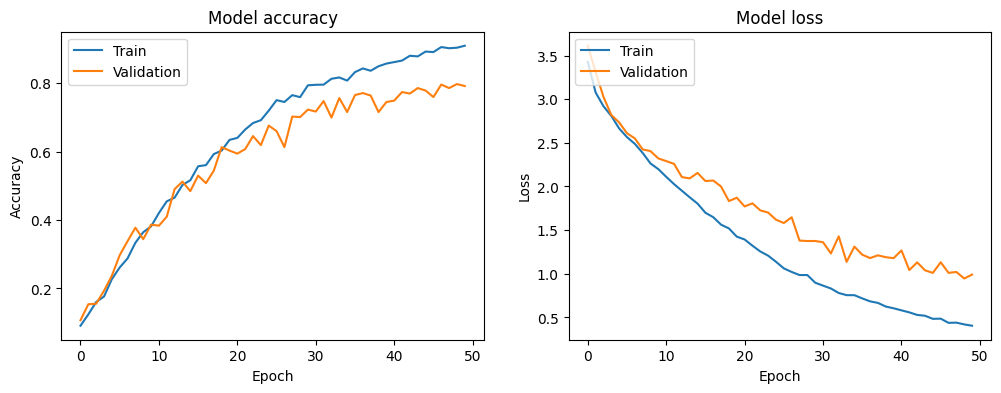

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chris\.conda\envs\ASLR\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

            A      0.462     0.750     0.571         8
            B      0.875     0.700     0.778        10
            C      0.833     0.556     0.667        18
            D      0.000     0.000     0.000         9
            E      0.842     0.941     0.889        17
            F      0.273     0.500     0.353         6
            G      0.667     0.889     0.762         9
            H      0.750     0.667     0.706         9
            I      0.938     0.714     0.811        21
            J      0.731     0.905     0.809        21
            K      0.667     0.727     0.696        11
            L      0.867     0.684     0.765        19
            M      0.750     0.429     0.545         7
            N      0.571     0.667     0.615         6
            O      0.846     1.000     0.917        22
            P      0.667     0.222     0.333         9
            Q      0.875     0.778     0.824         9
         

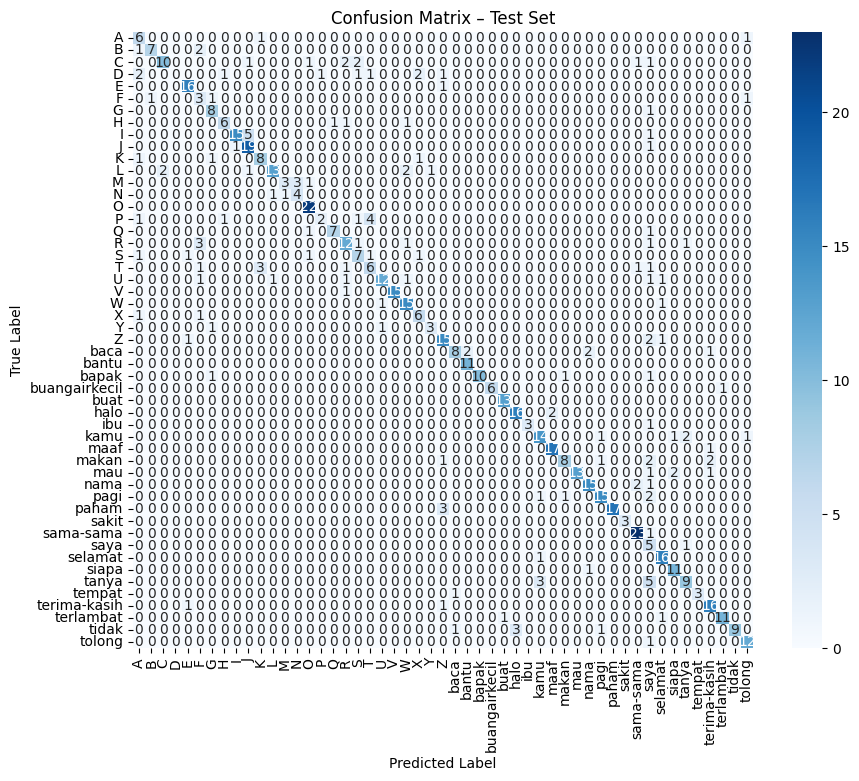

In [34]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()